# Wrangling and Analyse Data- The Tweet Archives of @dog_rates

## Table of Contents
<ul>
<a href="#intro">1.0 Introduction</a><br>
<a href="#questions">2.0 Questions</a><br>    
<a href="#wrangling">3.0 Data Wrangling</a><br>
<blockquote><a href="#gather">3.1 Gathering Data</a><br> 
<a href="#assess">3.2 Assessing Data</a><br>
<a href="#clean">3.3 Cleaning Data</a><br>
<a href="#reassess">3.4 Reassess and Iterate</a></blockquote>
<a href="#store">4.0 Storing Data</a><br>
<a href="#analyse">5.0 Analysing and Visualising Data</a><br>
<a href="#conclusion">6.0 Conclusion</a><br>
</ul>

<a id='intro'></a>
## Introduction
In this project, I wrangled, analysed and visualised data from the Twitter user- [@dog_rates](https://twitter.com/dog_rates), also known as **WeRateDogs**. WeRateDogs is a Twitter account that rates people's dogs based on pictures or videos with a humorous comment about the dog.<br>
These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10! 11/10, 12/10, 13/10, etc. Why? Because *"they're good dogs Brent."* WeRateDogs has over 4 million followers and has received international media coverage.<br> 
The **goal** of this project is to <i>'wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.'</i>

### Analysis Approach
This analysis was done systematically by performing the steps described below
1. **Questions:** I reviewed the available data sources and developed analysis questions.
2. **Wrangling:** This steps consist of:
> *Gathering data* from three sources - csv, tsv and Twitter API.<br>
> *Assessing data* visually and programmatically for data quality gaps<br>
> *Cleaning data* to address data quality gaps identified<br>
3. **Storing data** for easy retrieval of the cleaned data. Cleaning was done using the *define, code and test* approach.
4. **Analysing and visualising data** to explore the data, get clarity of the data and get the data story
6. **Reporting:** Two reports were created:
> * Data wrangling efforts and
> * Data analyses and visualizations

<a id='questions'></a>
## Questions
This project aims to answer the following questions.
1. What is the most popular dog_stage?
2. What breed of dog have the highest average rating?
3. Is there a relationship between rating, retweets, likes and breed of dog?
4. What is the best dog across category?

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

<a id='wrangling'></a>
## 3.0 Data Wrangling

<a id='gather'></a>
### 3.1 Gathering Data

1. **Enhanced Twitter Archive** (CSV) <br>
This csv file was shared internally by Udacity for this project. Therefore, it was **manually downloaded** into the project's folder.
> *'The WeRateDogs Twitter archive contains basic tweet data for all 5,000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2,356). This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5,000+ of their tweets as they stood on August 1, 2017'* - **Udacity**

In [2]:
# Read 'twitter-archive-enhanced.csv' file (csv) into DataFrame

twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head() #confirm

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. **Image Prediction**
<br>The link to this tsv file was shared by Udacity. It includes data on the breeds of dogs linked to the image and tweet ID. To ensure scalability and reproducibility, it was best to **download it programmatically**.
>'... I ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).' - **Udacity**

In [3]:
#download image_prediction file programmatically from Udacity server
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

#save HTML to file
with open("image_predictions.tsv", 'wb') as file:
    file.write(response.content)

> <b>Note:</b> Could not use this to save HTML to file because of the naming of the HTML which used a '-' causing python to see image-predictions as 2 different words and throw a `NameError` when the file is called.
<br>`with open(os.path.join(url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)`

In [4]:
# Read 'twitter-archive-enhanced.csv' file (csv) into DataFrame
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')
image_predictions.head() #confirm

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<b>3. Additional Data via the Twitter API</b>
<br>Retweet count and favorite count are missing from the available datasets, this additonal data was gathered  by querying Twitter's API using *Tweepy*. First, I applied and set up my own Twitter application.
<br> In line with standard practice, I did **not** include my API keys, secrets, and tokens in my project submission.


In [5]:
#Extract data programmatically from Twitter using Tweepy
consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'

In [6]:
# Create the Twitter API object and set rate limit params as Twitter's API has a rate limit.
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth_handler = auth, wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)


In [7]:
# Get a list of tweet_ids from the enhanced twitter archive
tweet_ids = twitter_archive['tweet_id'].values
            
count = 0 
tweets_json_list = [] # List of tweets
tweets_error_list = [] # create a list for tweets with exceptions/errors


start_time = time.time() # start time of execution

# For loop which will add each tweet json using the try-except blocks (to take care of deleted tweets 
#which might flag errors) to 'tweets_json_list' or 'tweets_error_list'

for tweet_id in tweet_ids:
    count += 1
    try:
        tweet = api.get_status(tweet_id, tweet_mode = 'extended')
        tweets_json_list.append(tweet._json)
    except tweepy.TweepError as e:
        print(str(tweet_id)+ " _ " + str(e))
        tweets_error_list.append(tweet_id)
    
# To save space, only print out loop/tweet id for every 100th tweet
    if count % 100 == 0:
        print("loop # " + str(count))
        
end_time = time.time() # end time for excution

#printing time for execution
print("Total time taken for execution", end_time - start_time)

time_taken = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))
print("\nTotal time taken for execution (HH:MM:SS):  " + time_taken + "\n")

# total tweets and error received from api
print("The length of the result: ", len(tweets_json_list))
print("Number of TweepErrors: ", len(tweets_error_list))

888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
loop # 100
872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 _ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 _ [{'code': 144, 'message': 'No status found with that ID.'}]
loop # 200
851953902622658560 _ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 _ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 _ [{'code': 144, 'message': 'No status found with that ID.'}]
837366

Rate limit reached. Sleeping for: 138


loop # 1400
loop # 1500
loop # 1600
loop # 1700
680055455951884288 _ [{'code': 144, 'message': 'No status found with that ID.'}]
loop # 1800
loop # 1900
loop # 2000
loop # 2100
loop # 2200


Rate limit reached. Sleeping for: 130


loop # 2300
Total time taken for execution 2669.7382521629333

Total time taken for execution (HH:MM:SS):  00:44:29

The length of the result:  2331
Number of TweepErrors:  25


In [8]:
# create dataframe
additional_data_file = pd.DataFrame(tweets_json_list)

# Write json data to txt file
additional_data_file.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)


# Read the saved tweet_json.txt file into a dataframe
additional_twitter_data = pd.read_csv('tweet_json.txt', encoding = 'utf-8')

#confirm shape
additional_twitter_data.shape 

(2331, 32)

In [9]:
additional_twitter_data.iloc[21]

created_at                                          Wed Jul 19 03:39:09 +0000 2017
id                                                              887517139158093824
id_str                                                          887517139158093824
full_text                        I've yet to rate a Venezuelan Hover Wiener. Th...
truncated                                                                    False
display_text_range                                                        [0, 108]
entities                         {'hashtags': [], 'symbols': [], 'user_mentions...
extended_entities                {'media': [{'id': 887517108413886465, 'id_str'...
source                           <a href="http://twitter.com/download/iphone" r...
in_reply_to_status_id                                                          NaN
in_reply_to_status_id_str                                                      NaN
in_reply_to_user_id                                                            NaN
in_r

<a id='assess'></a>
### 3.2 Assessing Data

With the data gathering process completed, I moved on to the next step in the data wrangling process- **Assessing the Data**. Each table was assessed visually and programmatically for quality (content) and tidiness (structural) issues as detailed in the following sections. Visual assessment was done using python and Microsoft Excel.

In [10]:
#Display complete contents of a dataframe without any kind of truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [11]:
#display a sample of twitter archive table
twitter_archive.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2168,669354382627049472,NaN,NaN,2015-11-25 03:18:15 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Dug. Dug fucken loves peaches. 8/10 https://t.co/JtA1TG21Xx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669354382627049472/photo/1,8,10,Dug,None,None,None,None
1742,679462823135686656,NaN,NaN,2015-12-23 00:45:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Hurley. He's the curly one. He hugs every other dog he sees during his walk. 11/10 for spreading the love https://t.co/M6vqkt2GKV,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679462823135686656/photo/1,11,10,Hurley,None,None,None,None
919,756526248105566208,NaN,NaN,2016-07-22 16:28:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",All hail sky doggo. 13/10 would jump super high to pet https://t.co/CsLRpqdeTF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/756526248105566208/photo/1,13,10,None,doggo,None,None,None
1345,704491224099647488,7.044857e+17,2.878549e+07,2016-03-01 02:19:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",13/10 hero af\n@ABC,NaN,NaN,NaN,NaN,13,10,None,None,None,None,None
490,813812741911748608,NaN,NaN,2016-12-27 18:24:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Gary, Carrie Fisher's dog. Idk what I can say about Gary that reflects the inspirational awesomeness that was Carrie Fisher. 14/10 RIP https://t.co/uBnQTNEeGg",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/813812741911748608/photo/1,https://twitter.com/dog_rates/status/813812741911748608/photo/1,https://twitter.com/dog_rates/status/813812741911748608/photo/1",14,10,Gary,None,None,None,None
2339,666102155909144576,NaN,NaN,2015-11-16 03:55:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my. Here you are seeing an Adobe Setter giving birth to twins!!! The world is an amazing place. 11/10 https://t.co/11LvqN4WLq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666102155909144576/photo/1,11,10,None,None,None,None,None
98,873213775632977920,NaN,NaN,2017-06-09 16:22:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps://t.co/Xp01EU3qyD https://t.co/V5lkvrGLdQ,NaN,NaN,NaN,"https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.com/dog_rates/status/873213775632977920/photo/1,https://twitter.com/dog_rates/status/873213775632977920/photo/1",12,10,Sierra,None,None,pupper,None
2242,667911425562669056,NaN,NaN,2015-11-21 03:44:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Wow. Armored dog here. Ready for battle. Face looks dangerous. Not very loyal. Lil dog on back havin a blast. 5/10 https://t.co/SyMoWrp368,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667911425562669056/photo/1,5,10,None,None,None,None,None
2225,668286279830867968,NaN,NaN,2015-11-22 04:33:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Rusty. Rusty's dreaming of a world where Twitter never got rid of favorites. Looks like a happy world. 11/10 https://t.co/C8U6cxI1Jc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668286279830867968/photo/1,11,10,Rusty,None,None,None,None
934,753420520834629632,NaN,NaN,2016-07-14 02:47:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we are witnessing an isolated squad of bouncing doggos. Unbelievably rare for this tim

In [12]:
#Assess column information
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
#Check for nulls
twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [14]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [15]:
# how many tweets with missing urls are replies or retweets?
sum(twitter_archive.expanded_urls.isna() & \
    (twitter_archive.in_reply_to_status_id.notnull() | \
     twitter_archive.retweeted_status_id.notnull()))

56

In [16]:
twitter_archive[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [17]:
#Access rating_numerator
twitter_archive.rating_numerator.value_counts().sort_index(ascending = False)
#0, and >14 appears to be outliers

1776      1
960       1
666       1
420       2
204       1
182       1
165       1
144       1
143       1
121       1
99        1
88        1
84        1
80        1
75        2
60        1
50        1
45        1
44        1
27        1
26        1
24        1
20        1
17        1
15        2
14       54
13      351
12      558
11      464
10      461
9       158
8       102
7        55
6        32
5        37
4        17
3        19
2         9
1         9
0         2
Name: rating_numerator, dtype: int64

In [18]:
# display tweets with numerator =0 
rating_numerator = (twitter_archive.rating_numerator == 0)
print(sum(rating_numerator))

cols = ['text', 'tweet_id', 'rating_numerator', 'rating_denominator', 'in_reply_to_status_id', 'retweeted_status_id']
twitter_archive[rating_numerator][cols]
#The numerators with 0s are accurate

2


,text,tweet_id,rating_numerator,rating_denominator,in_reply_to_status_id,retweeted_status_id
315,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,835152434251116546,0,10,NaN,NaN
1016,"PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",746906459439529985,0,10,7.468859e+17,NaN


In [19]:
# display tweets with numerator >= 14
rating_numerator2 = (twitter_archive.rating_numerator>14)
print(sum(rating_numerator2))

cols = ['text', 'tweet_id', 'rating_numerator', 'rating_denominator', 'in_reply_to_status_id', 'retweeted_status_id']
twitter_archive[rating_numerator2][cols]
#reviewed manually and identified 5 with inaccurate numerator which indicates a flaw with ratings that have fractions

28


,text,tweet_id,rating_numerator,rating_denominator,in_reply_to_status_id,retweeted_status_id
55,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,881633300179243008,17,10,8.816070e+17,NaN
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,855862651834028034,420,10,8.558616e+17,NaN
189,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",855860136149123072,666,10,8.558585e+17,NaN
285,RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI,838916489579200512,15,10,NaN,8.389060e+17
290,@markhoppus 182/10,838150277551247360,182,10,8.381455e+17,NaN
291,@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10,838085839343206401,15,10,8.380855e+17,NaN
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",835246439529840640,960,0,8.352460e+17,NaN
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",832215909146226688,75,10,NaN,7.867091e+17
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,820690176645140481,84,70,NaN,NaN
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,810984652412424192,24,7,NaN,NaN


In [20]:
#Access rating_denominator
twitter_archive.rating_denominator.value_counts().sort_index(ascending = False)
#!10 appears to be outliers

170       1
150       1
130       1
120       1
110       1
90        1
80        2
70        1
50        3
40        1
20        2
16        1
15        1
11        3
10     2333
7         1
2         1
0         1
Name: rating_denominator, dtype: int64

In [21]:
# display tweets that do not have denominator of 10
rating_denominator = (twitter_archive.rating_denominator != 10)
print(sum(rating_denominator))

cols = ['text', 'tweet_id', 'rating_numerator', 'rating_denominator', 'in_reply_to_status_id', 'retweeted_status_id']
twitter_archive[rating_denominator][cols]
#manually reviewed and identified 6 with inaccurate denominator

23


,text,tweet_id,rating_numerator,rating_denominator,in_reply_to_status_id,retweeted_status_id
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",835246439529840640,960,0,8.352460e+17,NaN
342,@docmisterio account started on 11/15/15,832088576586297345,11,15,8.320875e+17,NaN
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,820690176645140481,84,70,NaN,NaN
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,810984652412424192,24,7,NaN,NaN
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",775096608509886464,9,11,NaN,7.403732e+17
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,758467244762497024,165,150,NaN,NaN
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",740373189193256964,9,11,NaN,NaN
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,731156023742988288,204,170,NaN,NaN
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,722974582966214656,4,20,NaN,NaN
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,716439118184652801,50,50,NaN,NaN


In [22]:
#Assess dog name
twitter_archive.name.sample(20)

480        Akumi
1142        None
775            O
70          Beau
2346         the
763       Sophie
428         Luca
321       Wilson
1948     Pickles
738         Koda
1320        Koda
1839       Donny
1170    Berkeley
1903        None
1907        None
680         Lucy
1434     Bentley
1656        None
600         None
688        Frank
Name: name, dtype: object

In [23]:
#list all names that are NOT capitalized
dog_name = twitter_archive.name.str.contains('^[a-z]', regex = True)
print(len(twitter_archive[dog_name]))
twitter_archive[dog_name].name.value_counts().sort_index()

109


a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old              1
one              4
quite            4
space            1
such             1
the              8
this             1
unacceptable     1
very             5
Name: name, dtype: int64

In [24]:
#Assess stages of dod
print(twitter_archive.doggo.value_counts())
print(twitter_archive.floofer.value_counts())
print(twitter_archive.pupper.value_counts())
print(twitter_archive.puppo.value_counts())

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


In [25]:
#Sum
print(97+10+257+30)
#The sum of stage of dog (394) is way less that expected of approximately 2100. When combined, expect nulls

394


In [26]:
#display a sample of image prediction table
image_predictions.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1712,818588835076603904,https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg,1,Norwegian_elkhound,0.372202,True,Chesapeake_Bay_retriever,0.137187,True,malamute,0.071436,True
375,672997845381865473,https://pbs.twimg.com/media/CVb39_1XIAAMoIv.jpg,1,chow,0.517255,True,Pomeranian,0.206053,True,koala,0.127037,False
2032,883360690899218434,https://pbs.twimg.com/media/DEJT3FeXoAAtwUy.jpg,1,chow,0.987997,True,Tibetan_mastiff,0.007099,True,Newfoundland,0.002140,True
1493,783085703974514689,https://pbs.twimg.com/media/Ct4URfWUAAQ7lKe.jpg,1,Chesapeake_Bay_retriever,0.240602,True,Airedale,0.164088,True,boxer,0.134506,True
696,684481074559381504,https://pbs.twimg.com/media/CX_D6AJWwAAnBIw.jpg,1,Chihuahua,0.937810,True,Pomeranian,0.020307,True,polecat,0.017357,False
555,677662372920729601,https://pbs.twimg.com/media/CWeKTZTWsAA5R3Z.jpg,1,cowboy_hat,0.256110,False,trench_coat,0.127086,False,cloak,0.071439,False
499,675822767435051008,https://pbs.twimg.com/media/CWEBOFYWwAA-O2c.jpg,1,Pomeranian,0.460710,True,chow,0.202765,True,Pekinese,0.133266,True
320,671789708968640512,https://pbs.twimg.com/tweet_video_thumb/CVKtH-4WIAAmiQ5.png,1,dalmatian,0.114259,True,teddy,0.062275,False,steam_locomotive,0.049700,False
689,684188786104872960,https://pbs.twimg.com/media/CX66EiJWkAAVjA-.jpg,1,kelpie,0.537782,True,American_Staffordshire_terrier,0.082953,True,Staffordshire_bullterrier,0.069760,True
1690,815736392542261248,https://pbs.twimg.com/media/C1IT6rVXUAIvwYT.jpg,3,Border_collie,0.548907,True,Cardigan,0.178523,True,collie,0.146351,True


In [27]:
#Assess columns, datatype and check for nulls
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [28]:
# Assess dog species predicted
image_predictions.p1.value_counts().sort_index()

Afghan_hound                        4
African_crocodile                   1
African_grey                        1
African_hunting_dog                 1
Airedale                           12
American_Staffordshire_terrier     13
American_black_bear                 1
Angora                              2
Appenzeller                         2
Arabian_camel                       3
Arctic_fox                          4
Australian_terrier                  2
Bedlington_terrier                  5
Bernese_mountain_dog               10
Blenheim_spaniel                   11
Border_collie                      12
Border_terrier                      7
Boston_bull                         9
Brabancon_griffon                   3
Brittany_spaniel                    7
Cardigan                           19
Chesapeake_Bay_retriever           23
Chihuahua                          83
Christmas_stocking                  3
Dandie_Dinmont                      6
Doberman                            8
Egyptian_cat

In [29]:
#check number of non-dog species
image_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [30]:
#display additional twitter data table
additional_twitter_data.sample(10)

created_at                  id              id_str  \
1864  Thu Dec 10 02:15:47 +0000 2015  674774481756377088  674774481756377088   
2037  Mon Nov 30 03:06:07 +0000 2015  671163268581498880  671163268581498880   
2231  Fri Nov 20 18:09:16 +0000 2015  667766675769573376  667766675769573376   
1637  Fri Jan 01 21:00:32 +0000 2016  683030066213818368  683030066213818368   
358   Sun Feb 05 22:55:23 +0000 2017  828376505180889089  828376505180889089   
1518  Wed Jan 20 00:03:21 +0000 2016  689599056876867584  689599056876867584   
1561  Tue Jan 12 16:25:26 +0000 2016  686947101016735744  686947101016735744   
221   Sat Apr 01 01:08:10 +0000 2017  847978865427394560  847978865427394560   
465   Sun Jan 01 19:22:38 +0000 2017  815639385530101762  815639385530101762   
988   Mon Jun 27 01:37:04 +0000 2016  747242308580548608  747242308580548608   

                                                                                                                                         full_text  \
1864   This is Superpup. His head isn't proportional to his body. Has yet to serve any justice. 11/10 maybe one day pupper https://t.co/gxIFgg8ktm   
2037     Pack of horned dogs here. Very team-oriented bunch. All have weird laughs. Bond between them strong. 8/10 for all https://t.co/U7DQQdZ0mX   
2231   This is Calvin. He is a Luxembourgian Mayo. Having issues with truck. Has it under control tho. 9/10 responsible af https://t.co/3Bbba7y8Xe   
1637    This is Lulu. She's contemplating all her unreached 2015 goals and daydreaming of a more efficient tomorrow. 10/10 https://t.co/h3ScYuz77J   
358       This is Beebop. Her name means "Good Dog" in robot. She also was a star on the field today. 13/10 would pet well https://t.co/HKBVZqXFNR   
1518                                        Here we see 33 dogs posing for a picture. All get 11/10 for superb cooperation https://t.co/TRAri5iHzd   
1561     This is Jackson. He was specifically told not to sleep in the fridge. Damn it Jackson. 11/10 would squeeze softly https://t.co/lJs10ZJsgj   
221   RT @dog_rates: This is Charlie. He fell asleep on a heating vent. Would puppreciate your assistance. 11/10 someone help Charlie https://t.c…   
465                   This is Titan. His nose is quite chilly. Requests to return to the indoors. 12/10 would boop to warm https://t.co/bLZuOh9sKy   
988   RT @dog_rates: This pupper killed this great white in an epic sea battle. Now wears it as a trophy. Such brave. Much fierce. 13/10 https://…   

      truncated display_text_range  \
1864      False           [0, 139]   
2037      False           [0, 137]   
2231      False           [0, 139]   
1637      False           [0, 138]   
358       False           [0, 112]   
1518      False           [0, 102]   
1561      False           [0, 137]   
221       False           [0, 140]   
465       False           [0, 100]   
988       False           [0, 140]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     entities  \
1864    {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 674774472939970560, 'id_str': '674774472939970560', 'indices': [116, 139], 'media_url': 'http://pbs.twimg.com/media/CV1HztsWoAAuZwo.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CV1HztsWoAAuZwo.jpg', 'url': 'https://t.co/gxIFgg8ktm', 'display_url': 'pic.twitter.com/gxIFgg8ktm', 'expanded

In [31]:
#Assess columns, datatypes and check for nulls
additional_twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2331 non-null   object 
 1   id                             2331 non-null   int64  
 2   id_str                         2331 non-null   int64  
 3   full_text                      2331 non-null   object 
 4   truncated                      2331 non-null   bool   
 5   display_text_range             2331 non-null   object 
 6   entities                       2331 non-null   object 
 7   extended_entities              2059 non-null   object 
 8   source                         2331 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     float64
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     f

In [32]:
#assess truncated
additional_twitter_data.truncated.value_counts()

False    2331
Name: truncated, dtype: int64

In [33]:
#assess source
additional_twitter_data.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2197
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [34]:
#assess other columns
print(additional_twitter_data.retweeted.value_counts())
print(additional_twitter_data.favorited.value_counts())
print(additional_twitter_data.possibly_sensitive.value_counts())
print(additional_twitter_data.possibly_sensitive_appealable.value_counts())
print(additional_twitter_data.lang.value_counts())

False    2331
Name: retweeted, dtype: int64
False    2331
Name: favorited, dtype: int64
False    2196
Name: possibly_sensitive, dtype: int64
False    2196
Name: possibly_sensitive_appealable, dtype: int64
en     2313
und       7
nl        3
in        3
eu        1
es        1
et        1
ro        1
tl        1
Name: lang, dtype: int64


In [35]:
#save additional twitter table to csv and assess in spreadsheet
additional_twitter_data.to_csv('other_data.csv')

#### Notes

**Quality**
- Twitter Archive: 78 Reply tweets are included  re:`in_reply_to_status_id`
- Twitter Archive:`timestamp` in string format instead of datetime
- Twitter Archive: The `source` is in link which can be shorthened
- Twitter Archive: 181 Retweets  are included  re: `retweeted_status_id`
- Twitter Archive: 59 missing `expanded_urls` which indicates no image, out of which 56 are either replies or retweets
- Twitter Archive: 30 'Outlier' `rating_numerator` (defined as 0, and >14) which includes retweets and replies  were assessed. The following `tweet_ids` are neither replies or retweets and have inaccurate numerator.
>810984652412424192 (referenced 24/7),<br>
786709082849828864(fraction),<br>
778027034220126208 (fraction),<br>
716439118184652801 (wrong),<br>
680494726643068929 (fraction) <br>
- Twitter Archive: 23 'Outlier' `rating_denominator` (defined as != 10) which includes retweets and replies  were assessed. 6 `tweet_ids` which  are neither replies or retweets were identified inaccurate denominator. They are:
> 810984652412424192<br>
775096608509886464<br>
722974582966214656<br>
716439118184652801<br>
682962037429899265<br>
666287406224695296<br>
- Twitter Archive: `rating_denominator` greater than 10
- Twitter Archive: 109 inaccurate `name` which includes adjectives - a, an, very, etc. It was observed that correctly extracted (accurate) dog names start in caps
- Twitter Archive: missing data in `name` re: `name` = None.
- Twitter Archive: Potential of missing values in stage of dog- `doggo`, `floofer`, `pupper` and `puppo` probably due to spelling variations or missing stage (in `text`)
- Image prediction: In tweets with multiple images re:`image_num` >1, what happens?
- Image prediction: 543 non-dog species such as cardigan, zebra, bookshop, web_site etc, returned.re:`p1_dog`= False
- Additional data: `source` is in link which can be shorthened
- Additinal data: Reply tweets are included  re:`in_reply_to_status_id`, `in_reply_to_user_id`, `in_reply_to_screen_name` 
- Additinal data: Retweets tweets are included

**Tidiness**
- Twitter Archive: Stages of dog - doggo, pupper, puppy and floff(er) is in four columns
- Twitter Archive: reply columns (`in_reply_to_status_id` and `in_reply_to_user_id`)  are not applicable
- Twitter Archive: Retweet columns (`retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` are not applicable
- Twitter Archive: `rating_denominator` not applicable if all =10
- Image prediction: columns have non-descriptive names
- Image predictions: `p1_dog` not applicable if =False are removed
- Image predictions: `p1_conf` not appplicable since p1 was taken as it has the highest confidence
- Image predictions: `p2`,`p2_conf`,`p2_dog`,`p3`,`p3_conf` and `p3_dog` are not applcable
- Additional data: repeated columns in different data type including re: `id_str`, `in_reply_to_status_id_str` `in_reply_to_user_id_str` and `quoted_status_id_str`
- Additional data: `truncated` is irrelevant as all = False.
- Additional data: irrelevant columns re: `users`, `geo`, `coordinates`, `place`, `contributors`, `is_quote_status`, `possibly_sensitive`,`possibly_sensitive_appealable`, `lang`, `retweeted_status`, `quoted_status_id`, `quoted_status_id_str`, `quoted_status_permalink` and `quoted_status`
- Additional data: `favorited` is irrelevant as all = False.
- Additional data: `retweeted` is irrelevant as all = False.

<a id='clean'></a>
### 3.3 Cleaning Data

In this third step of the data wrangling process and to meet the project specification, I will clean
- 9+  quality issues
- 5+  tidiness issues
Cleaning was done using the define, code and test steps. 
I choose to clean the issues documented in the table below whcih are relevant to my research questions.

| s_no | issue | table| type |
| --- | --- | --- | --- |
| 1 | 78 Reply tweets are included re:`in_reply_to_status_id` | twitter archive | quality |
| 2 | `timestamp` in string format instead of datetime | twitter archive | quality |
| 3 | 181 Retweets are included re: `retweeted_status_id` | twitter archive | quality |
| 4 | The source is in link which can be shorthened | twitter archive | quality |
| 5 | missing expanded_urls | twitter archive | quality |
| 6 | 'Outlier' `rating_numerator`  | twitter archive | quality |
| 7 | 'Outlier' `rating_denominator` | twitter archive  | quality |
| 8 | `rating_denominator` != 10 | twitter archive | quality |
| 9 | 543 non-dog species re:`p1_dog`= False | image prediction | quality |
| 10 |  Stages of dog - `doggo`, `pupper`, `puppy` and `floff`(er) is in four columns | twitter archive | tidiness |
| 11 | reply columns (`in_reply_to_status_id` and `in_reply_to_user_id`) are not applicable | twitter archive | tidiness |
| 12 | Retweet columns (`retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` are not applicable| twitter archive | tidiness |
| 13 | `rating_denominator` not applicable if all =10| twitter archive | tidiness 
| 14 | columns have non-descriptive names | image prediction | tidiness |

<br> Finally, I **join** image prediction and additonal twitter data tables to twitter archive table.

In [36]:
# create copies of the dataframes for cleaning
archive_clean = twitter_archive.copy()
predictions_clean = image_predictions.copy()
additional = additional_twitter_data.copy()

##### Quality 1 - 78 Reply tweets are included re: `in_reply_to_status_id` [archive]

###### Define
- Drop all rows with reply tweets where `in_reply_to_status_id` is notnull

###### Code

In [37]:
#drop all reply tweets
print("Before cleaning, reply tweets were: {}".format(sum(archive_clean.in_reply_to_status_id.notnull())))
archive_clean = archive_clean[archive_clean.in_reply_to_status_id.isna()]

Before cleaning, reply tweets were: 78


###### Test

In [38]:
#confirm
print("After cleaning, reply tweets were: {}".format(sum(archive_clean.in_reply_to_status_id.notnull())))

After cleaning, reply tweets were: 0


##### Quality 2 - `timestamp` in string format instead of datetime [archive]

###### Define
- Convert `timestamp` from string to datetime

###### Code

In [39]:
#Convert timestamp from strint to datetime
print(archive_clean.dtypes)
archive_clean['timestamp'] = pd.to_datetime(archive_clean.timestamp)

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object


###### Test

In [40]:
#confirm
print(archive_clean.dtypes)

tweet_id                                    int64
in_reply_to_status_id                     float64
in_reply_to_user_id                       float64
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                       float64
retweeted_status_user_id                  float64
retweeted_status_timestamp                 object
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
dtype: object


##### Quality 3 - 181 Retweets are included re: `retweeted_status_id` [archive]

###### Define
- Drop all rows with retweets where `retweeted_status_id` is notnull

###### Code

In [41]:
# drop retweets
print("Before cleaning, retweets were: {}".format(sum(archive_clean.retweeted_status_id.notnull())))
archive_clean = archive_clean[archive_clean.retweeted_status_id.isna()]

Before cleaning, retweets were: 181


In [42]:
#test
print("After cleaning, retweets were: {}".format(sum(archive_clean.retweeted_status_id.notnull())))

After cleaning, retweets were: 0


##### Quality 4 - The `source` is in link which can be shorthened [archive]

###### Define
- Extract the string between `<a href=""> and </a>`
- Replace the `source` url with the string

###### Code

In [43]:
#before cleaning
archive_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1964
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

###### Test

In [44]:
archive_clean['source'] = archive_clean['source'].str.extract('^<a.+>(.+)</a>$')

In [45]:
archive_clean.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

##### Quality 5 - missing expanded_urls [archive]

###### Define
- drop tweets with missing data in `expanded_url`

###### Code

In [46]:
#check number of affected rows
print(sum(archive_clean['expanded_urls'].isnull()))

#drop rows with expanded url isnull
archive_clean = archive_clean[archive_clean.expanded_urls.notnull()]

3


###### Test

In [47]:
#Confirm
print(sum(archive_clean['expanded_urls'].isnull()))

0


##### Quality 6 and 7 - 'Outlier' `rating_numerator` and `rating_denominator` [archive]

###### Define
- drop tweet_id - 810984652412424192 as it does not have a rating (row 516)
- change datatype for `rating_numerator` to float to accept decimals
- replace numerator/denominator for the following:
> - 722974582966214656 - replace 4/20 by 13/10
> - 716439118184652801 - replace 50/50 with 11/10
> - 682962037429899265 - replace 7/11 with 10/10
> - 666287406224695296 - replace 1/2 with 9/10
> - 786709082849828864 - replace 75/10 with 9.75/10
> - 778027034220126208 - replace 27/10 with 11.27/10
> - 680494726643068929 - replace 26/10 with 11.26/10

###### Code

In [48]:
#review data for tweet_id - 810984652412424192
archive_clean.loc[archive_clean['tweet_id']==810984652412424192]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23+00:00,Twitter for iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None


In [49]:
#drop tweet_id 810984652412424192 as no rating is available
archive_clean.drop(archive_clean.loc[archive_clean['tweet_id']==810984652412424192].index, inplace=True)

###### Test

In [50]:
#confirm
archive_clean.loc[archive_clean['tweet_id']==810984652412424192]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


###### Code

In [51]:
#Assess before cleaning
print(archive_clean.dtypes)

#change rating_numerator from int to float
archive_clean['rating_numerator'] = archive_clean['rating_numerator'].astype(float)

tweet_id                                    int64
in_reply_to_status_id                     float64
in_reply_to_user_id                       float64
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                       float64
retweeted_status_user_id                  float64
retweeted_status_timestamp                 object
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
dtype: object


###### Test

In [52]:
#confirm
print(archive_clean.dtypes)

tweet_id                                    int64
in_reply_to_status_id                     float64
in_reply_to_user_id                       float64
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                       float64
retweeted_status_user_id                  float64
retweeted_status_timestamp                 object
expanded_urls                              object
rating_numerator                          float64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
dtype: object


###### Code

In [53]:
#Assess affected tweets
archive_clean[(archive_clean.tweet_id == 722974582966214656) | \
              (archive_clean.tweet_id == 716439118184652801) | \
              (archive_clean.tweet_id == 682962037429899265) | \
              (archive_clean.tweet_id == 666287406224695296) | \
              (archive_clean.tweet_id == 786709082849828864) | \
              (archive_clean.tweet_id == 778027034220126208) | \
              (archive_clean.tweet_id == 680494726643068929) ][cols]

,text,tweet_id,rating_numerator,rating_denominator,in_reply_to_status_id,retweeted_status_id
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",786709082849828864,75.0,10,NaN,NaN
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,778027034220126208,27.0,10,NaN,NaN
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,722974582966214656,4.0,20,NaN,NaN
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,716439118184652801,50.0,50,NaN,NaN
1662,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,682962037429899265,7.0,11,NaN,NaN
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,680494726643068929,26.0,10,NaN,NaN
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,666287406224695296,1.0,2,NaN,NaN


In [54]:
#replace numerator/denominator
num_row = archive_clean.tweet_id == 722974582966214656
archive_clean.loc[num_row, 'rating_numerator'] = 13
archive_clean.loc[num_row, 'rating_denominator'] = 10

num_row = archive_clean.tweet_id == 716439118184652801
archive_clean.loc[num_row, 'rating_numerator'] = 11
archive_clean.loc[num_row, 'rating_denominator'] = 10

num_row = archive_clean.tweet_id == 682962037429899265
archive_clean.loc[num_row, 'rating_numerator'] = 10
archive_clean.loc[num_row, 'rating_denominator'] = 10

num_row = archive_clean.tweet_id == 666287406224695296
archive_clean.loc[num_row, 'rating_numerator'] = 9
archive_clean.loc[num_row, 'rating_denominator'] = 10

num_row = archive_clean.tweet_id == 786709082849828864
archive_clean.loc[num_row, 'rating_numerator'] = 9.75
archive_clean.loc[num_row, 'rating_denominator'] = 10

num_row = archive_clean.tweet_id == 778027034220126208
archive_clean.loc[num_row, 'rating_numerator'] = 11.27
archive_clean.loc[num_row, 'rating_denominator'] = 10

num_row = archive_clean.tweet_id == 680494726643068929
archive_clean.loc[num_row, 'rating_numerator'] = 11.26
archive_clean.loc[num_row, 'rating_denominator'] = 10


###### Test

In [55]:
#confirm
archive_clean[(archive_clean.tweet_id == 722974582966214656) | \
              (archive_clean.tweet_id == 716439118184652801) | \
              (archive_clean.tweet_id == 682962037429899265) | \
              (archive_clean.tweet_id == 666287406224695296) | \
              (archive_clean.tweet_id == 786709082849828864) | \
              (archive_clean.tweet_id == 778027034220126208) | \
              (archive_clean.tweet_id == 680494726643068929) ][cols]

,text,tweet_id,rating_numerator,rating_denominator,in_reply_to_status_id,retweeted_status_id
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",786709082849828864,9.75,10,NaN,NaN
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,778027034220126208,11.27,10,NaN,NaN
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,722974582966214656,13.00,10,NaN,NaN
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,716439118184652801,11.00,10,NaN,NaN
1662,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,682962037429899265,10.00,10,NaN,NaN
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,680494726643068929,11.26,10,NaN,NaN
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,666287406224695296,9.00,10,NaN,NaN


##### Quality 8 - rating_denominator != 10 [archive]

###### Define
- drop all rows with rating denominator != 10

###### Code

In [56]:
# assess
print(archive_clean.rating_denominator.value_counts().sort_index(ascending = False))
archive_clean = archive_clean[archive_clean.rating_denominator == 10]

170       1
150       1
120       1
110       1
90        1
80        2
70        1
50        2
40        1
11        1
10     2081
Name: rating_denominator, dtype: int64


###### Test

In [57]:
print(archive_clean.rating_denominator.value_counts().sort_index(ascending = False))

10    2081
Name: rating_denominator, dtype: int64


##### Tidiness 1 - Stages of dog - `doggo`, `pupper`, `puppo` and `floffer` is in four columns [archive]

###### Define
- combine columns - `doggo`, `pupper`, `puppo` and `floffer`

###### Code

In [58]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2081 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2081 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2081 non-null   datetime64[ns, UTC]
 4   source                      2081 non-null   object             
 5   text                        2081 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2081 non-null   object             
 10  rating_numerator            2081 non-null   float64         

In [59]:
#Assess
print(archive_clean.doggo.value_counts())
print(archive_clean.floofer.value_counts())
print(archive_clean.pupper.value_counts())
print(archive_clean.puppo.value_counts())

None     1998
doggo      83
Name: doggo, dtype: int64
None       2071
floofer      10
Name: floofer, dtype: int64
None      1852
pupper     229
Name: pupper, dtype: int64
None     2057
puppo      24
Name: puppo, dtype: int64


In [60]:
#replace dog stage name with 1, and none with 0
make_dummy = lambda x: 0 if x == 'None' else 1

archive_clean.doggo = archive_clean.doggo.apply(make_dummy)
archive_clean.floofer = archive_clean.floofer.apply(make_dummy)
archive_clean.pupper = archive_clean.pupper.apply(make_dummy)
archive_clean.puppo = archive_clean.puppo.apply(make_dummy)

# Create new column - None by adding the stage columns
archive_clean['none'] = archive_clean['doggo'] + archive_clean['floofer'] + \
                        archive_clean['pupper'] + archive_clean['puppo']

# assess
archive_clean['none'].value_counts()

0    1746
1     324
2      11
Name: none, dtype: int64

In [61]:
# Set 'None' to 1 if No stage is specified
stage_none = lambda x: 1 if x == 0 else 0

# reset values in 'none' 
archive_clean['none'] = archive_clean['none'].apply(stage_none)

# set the choice order for dog stage
dog_stage = ['floofer', 'puppo', 'doggo', 'pupper', 'none']

# set the conditions for selecting the dog stage based on count order
conditions = [
    (archive_clean[dog_stage[0]] == 1),
    (archive_clean[dog_stage[1]] == 1),
    (archive_clean[dog_stage[2]] == 1),
    (archive_clean[dog_stage[3]] == 1),
    (archive_clean[dog_stage[4]] == 1)]

# select the dog stage based on the first successful condition; stage[4] is 'None'
archive_clean['dog_stage'] = np.select(conditions, dog_stage, default = dog_stage[4])

# drop the original 4 dog stage columns, and the temporary 'None'
archive_clean.drop(dog_stage, axis = 1, inplace = True)

# set the 'stage' column data type to category
archive_clean['dog_stage'] = archive_clean.dog_stage.astype('category')

###### Test

In [62]:
#Assess
archive_clean.dog_stage.value_counts()

none       1746
pupper      220
doggo        81
puppo        24
floofer      10
Name: dog_stage, dtype: int64

In [63]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2081 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2081 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2081 non-null   datetime64[ns, UTC]
 4   source                      2081 non-null   object             
 5   text                        2081 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2081 non-null   object             
 10  rating_numerator            2081 non-null   float64         

##### Tidiness 2, 3 and 4 [archive]
- reply columns (in_reply_to_status_id and in_reply_to_user_id) are not applicable
- Retweet columns (retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp are not applicable
- rating_denominator not applicable if all =10

###### Define
- confirm all rating_denominator = 10
- drop columns - `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`,`retweeted_status_timestamp` and `rating_denominator`  

###### Code

In [64]:
#confirm all rating_denominator = 10
archive_clean.rating_denominator.value_counts()

10    2081
Name: rating_denominator, dtype: int64

In [65]:
#drop columns
drop_columns = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',\
             'retweeted_status_user_id','retweeted_status_timestamp','rating_denominator']

archive_clean.drop(drop_columns, inplace=True, axis=1)

In [66]:
#rename column headers
archive_clean.rename(index = str, columns = {'rating_numerator': 'rating_over_10', 'name': 'dog_name'}, inplace = True)

###### Test

In [67]:
list(archive_clean.columns)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_over_10',
 'dog_name',
 'dog_stage']

##### Tidiness 5 - columns have non-descriptive names [prediction]

###### Define
- rename column headers using descriptive names

###### Code

In [68]:
#check column names
list(predictions_clean.columns)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [69]:
#rename column headers
predictions_clean.rename(index = str, columns = {'jpg_url': 'image_url', 'p1': 'dog_breed_prediction', 'p1_conf': 'prediction_confidence'}, inplace = True)

###### Test

In [70]:
#check header names
list(predictions_clean.columns)

['tweet_id',
 'image_url',
 'img_num',
 'dog_breed_prediction',
 'prediction_confidence',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

<a id='reassess'></a>

##### 2.4 Reassess and Iterate

###### Assess
- merge `archive_clean` to `predictions_clean` to create `master_clean`
- merge `master_clean` to `additional`
- reiterate assess and clean steps
> - drop columns not relevant to analysis and duplicate columns
> - use descriptive header
> - check for nulls and missing values
> - check datatypes

###### Define, Code and Test

In [71]:
#note shape
archive_clean.shape

(2081, 8)

In [72]:
#merge `archive_clean` with `predictions_clean`
master_clean = archive_clean.merge(predictions_clean, on='tweet_id', how='left')

#merge `master_clean` with `additional`
master_clean = master_clean.merge(additional, left_on='tweet_id', right_on='id', how='left')

In [73]:
# check shape
master_clean.shape

(2081, 51)

##### Quality 9 - 543 non-dog species re: `p1_dog`= False [prediction]

> **Note:** Had to move this stage after cleaning tidiness issues and merging because it was observed that some tweets rated non-dog. Therefore, this will be useful to take that out.

###### Define
- drop all rows with p1_dog == False

###### Code

In [74]:
# assess rows to drop
print(master_clean.p1_dog.value_counts())

master_clean.drop(master_clean.loc[master_clean['p1_dog']==False].index, inplace=True)

True     1452
False     506
Name: p1_dog, dtype: int64


###### Test

In [75]:
#confirm
print(master_clean.p1_dog.value_counts())

True    1452
Name: p1_dog, dtype: int64


In [76]:
list(master_clean.columns)

['tweet_id',
 'timestamp',
 'source_x',
 'text',
 'expanded_urls',
 'rating_over_10',
 'dog_name',
 'dog_stage',
 'image_url',
 'img_num',
 'dog_breed_prediction',
 'prediction_confidence',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'created_at',
 'id',
 'id_str',
 'full_text',
 'truncated',
 'display_text_range',
 'entities',
 'extended_entities',
 'source_y',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'user',
 'geo',
 'coordinates',
 'place',
 'contributors',
 'is_quote_status',
 'retweet_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'possibly_sensitive',
 'possibly_sensitive_appealable',
 'lang',
 'retweeted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'quoted_status']

In [77]:
#drop columns
drop_columns = ['img_num', 'image_url', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'created_at', 'id',\
       'id_str','full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities','source_y',\
       'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str',\
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status',\
       'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang',\
       'retweeted_status','quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink','quoted_status']

master_clean.drop(drop_columns, inplace=True, axis=1)

In [78]:
#confirm
list(master_clean.columns)

['tweet_id',
 'timestamp',
 'source_x',
 'text',
 'expanded_urls',
 'rating_over_10',
 'dog_name',
 'dog_stage',
 'dog_breed_prediction',
 'prediction_confidence',
 'retweet_count',
 'favorite_count']

In [79]:
#rename column header
master_clean.rename(index = str, columns = {'source_x': 'source'}, inplace = True)

In [80]:
# reorder columns
col_list = ['tweet_id', 'timestamp', 'text', 'rating_over_10', 'retweet_count', 'favorite_count',
            'dog_name', 'dog_stage', 'dog_breed_prediction', 'prediction_confidence','source', 'expanded_urls']

master_clean = master_clean[col_list]

In [81]:
#assess
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1575 entries, 1 to 2080
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1575 non-null   int64              
 1   timestamp              1575 non-null   datetime64[ns, UTC]
 2   text                   1575 non-null   object             
 3   rating_over_10         1575 non-null   float64            
 4   retweet_count          1568 non-null   float64            
 5   favorite_count         1568 non-null   float64            
 6   dog_name               1575 non-null   object             
 7   dog_stage              1575 non-null   category           
 8   dog_breed_prediction   1452 non-null   object             
 9   prediction_confidence  1452 non-null   float64            
 10  source                 1575 non-null   object             
 11  expanded_urls          1575 non-null   object             
dt

In [82]:
#visually assess nulls in retweet_count and favorite_count
retweet_count_null= (master_clean.retweet_count.isna())
print(sum(retweet_count_null))
master_clean[retweet_count_null]

7


,tweet_id,timestamp,text,rating_over_10,retweet_count,favorite_count,dog_name,dog_stage,dog_breed_prediction,prediction_confidence,source,expanded_urls
90,872261713294495745,2017-06-07 01:19:32+00:00,This is Harry. His ears are activated one at a time. Incredibly rare to witness in person. Very special moment here. 13/10 blessed as h*ck https://t.co/ejHvGDfWoa,13.0,NaN,NaN,Harry,none,Labrador_retriever,0.972019,Twitter for iPhone,"https://twitter.com/dog_rates/status/872261713294495745/photo/1,https://twitter.com/dog_rates/status/872261713294495745/photo/1"
202,844704788403113984,2017-03-23 00:18:10+00:00,This is Luna. It's her first time outside and a bee stung her nose. Completely h*ckin uncalled for. 13/10 where's the bee I just wanna talk https://t.co/2RYiLGHuPN,13.0,NaN,NaN,Luna,none,Labrador_retriever,0.980213,Twitter for iPhone,https://twitter.com/dog_rates/status/844704788403113984/photo/1
234,837366284874571778,2017-03-02 18:17:34+00:00,This is Lucy. She has a portrait of herself on her ear. Excellent for identification pupposes. 13/10 innovative af https://t.co/uNmxbL2lns,13.0,NaN,NaN,Lucy,none,American_Staffordshire_terrier,0.660085,Twitter for iPhone,https://twitter.com/dog_rates/status/837366284874571778/photo/1
284,829374341691346946,2017-02-08 17:00:26+00:00,This is Astrid. She's a guide doggo in training. 13/10 would follow anywhere https://t.co/xo7FZFIAao,13.0,NaN,NaN,Astrid,doggo,Staffordshire_bullterrier,0.757547,Twitter for iPhone,"https://twitter.com/dog_rates/status/829374341691346946/photo/1,https://twitter.com/dog_rates/status/829374341691346946/photo/1"
571,779123168116150273,2016-09-23 01:00:13+00:00,This is Reggie. He hugs everyone he meets. 12/10 keep spreading the love Reggie https://t.co/uMfhduaate,12.0,NaN,NaN,Reggie,none,toy_poodle,0.431080,Twitter for iPhone,https://twitter.com/dog_rates/status/779123168116150273/photo/1
722,754011816964026368,2016-07-15 17:56:40+00:00,This is Charlie. He pouts until he gets to go on the swing. 12/10 manipulative af https://t.co/ilwQqWFKCh,12.0,NaN,NaN,Charlie,none,French_bulldog,0.600985,Twitter for iPhone,"https://twitter.com/dog_rates/status/754011816964026368/photo/1,https://twitter.com/dog_rates/status/754011816964026368/photo/1"
1474,680055455951884288,2015-12-24 16:00:30+00:00,"Meet Sammy. At first I was like ""that's a snowflake. we only rate dogs,"" but he would've melted by now, so 10/10 https://t.co/MQfPK4zwuh",10.0,NaN,NaN,Sammy,none,Samoyed,0.995466,TweetDeck,https://twitter.com/dog_rates/status/680055455951884288/photo/1


In [83]:
#drop nulls in retweet and favorite count
master_clean = master_clean.dropna(axis=0, subset=['retweet_count'], inplace=False)

In [84]:
#assess
master_clean.describe()

,tweet_id,rating_over_10,retweet_count,favorite_count,prediction_confidence
count,1.568000e+03,1568.000000,1568.000000,1568.000000,1445.000000
mean,7.409428e+17,10.964464,2498.187500,8542.412628,0.613345
std,6.797445e+16,1.686828,4418.470757,12266.668292,0.260409
min,6.660209e+17,2.000000,11.000000,70.000000,0.044333
25%,6.791560e+17,10.000000,579.750000,2000.500000,0.389513
50%,7.161832e+17,11.000000,1279.000000,4079.500000,0.613819
75%,7.932752e+17,12.000000,2858.500000,10648.750000,0.850050
max,8.921774e+17,14.000000,76281.000000,153977.000000,0.999956


In [85]:
#change retweet_count and favorite_count to int

master_clean['retweet_count'] = master_clean['retweet_count'].astype(int)
master_clean['favorite_count'] = master_clean['favorite_count'].astype(int)

In [86]:
#confirm
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1568 entries, 1 to 2080
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1568 non-null   int64              
 1   timestamp              1568 non-null   datetime64[ns, UTC]
 2   text                   1568 non-null   object             
 3   rating_over_10         1568 non-null   float64            
 4   retweet_count          1568 non-null   int64              
 5   favorite_count         1568 non-null   int64              
 6   dog_name               1568 non-null   object             
 7   dog_stage              1568 non-null   category           
 8   dog_breed_prediction   1445 non-null   object             
 9   prediction_confidence  1445 non-null   float64            
 10  source                 1568 non-null   object             
 11  expanded_urls          1568 non-null   object             
dt

In [87]:
master_clean.sample(10)

,tweet_id,timestamp,text,rating_over_10,retweet_count,favorite_count,dog_name,dog_stage,dog_breed_prediction,prediction_confidence,source,expanded_urls
546,783391753726550016,2016-10-04 19:42:03+00:00,Meet Godi. He's an avid beachgoer and part time rainbow summoner. Eyeliner flawless af. 13/10 would snug well https://t.co/BO936YdJdi,13.0,5477,16949,Godi,none,Norwegian_elkhound,0.877130,Twitter for iPhone,"https://twitter.com/dog_rates/status/783391753726550016/photo/1,https://twitter.com/dog_rates/status/783391753726550016/photo/1,https://twitter.com/dog_rates/status/783391753726550016/photo/1,https://twitter.com/dog_rates/status/783391753726550016/photo/1"
380,813217897535406080,2016-12-26 03:00:30+00:00,Here is Atlas. He went all out this year. 13/10 downright magical af https://t.co/DVYIZOnO81,13.0,7303,18711,Atlas,none,Samoyed,0.905972,Twitter for iPhone,"https://twitter.com/dog_rates/status/813217897535406080/photo/1,https://twitter.com/dog_rates/status/813217897535406080/photo/1,https://twitter.com/dog_rates/status/813217897535406080/photo/1,https://twitter.com/dog_rates/status/813217897535406080/photo/1"
878,735648611367784448,2016-05-26 01:47:51+00:00,*faints* 12/10 perfection in pupper form https://t.co/t6TxTwTLEK,12.0,1080,3962,None,pupper,Pembroke,0.462594,Twitter for iPhone,https://twitter.com/dog_rates/status/735648611367784448/photo/1
743,751583847268179968,2016-07-09 01:08:47+00:00,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,5.0,1087,4342,None,doggo,dalmatian,0.868304,Twitter for iPhone,https://twitter.com/dog_rates/status/751583847268179968/photo/1
1068,707776935007539200,2016-03-10 03:55:45+00:00,This is Sadie. She's a Bohemian Rhapsody. Remarkably portable. Could sneak on roller coasters with (probably). 11/10 https://t.co/DB8fyeDs8B,11.0,938,3223,Sadie,none,miniature_pinscher,0.890426,Twitter for iPhone,https://twitter.com/dog_rates/status/707776935007539200/photo/1
162,853760880890318849,2017-04-17 00:03:50+00:00,Say hello to Alice. I'm told she enjoys car rides and smells good. 12/10 would give her everything she could ever want https://t.co/yT4vw8y77x,12.0,5477,27573,Alice,none,miniature_pinscher,0.292519,Twitter for iPhone,https://twitter.com/dog_rates/status/853760880890318849/photo/1
1342,686760001961103360,2016-01-12 04:01:58+00:00,This pupper forgot how to walk. 12/10 happens to all of us (vid by @bbuckley96) https://t.co/KFTrkSOuu3,12.0,1354,3461,None,pupper,NaN,NaN,Vine - Make a Scene,https://vine.co/v/iMvubwT260D
392,812781120811126785,2016-12-24 22:04:54+00:00,This is Swagger. He's the Cleveland Browns ambassador. Hype as h*ck after that first win today. 10/10 https://t.co/lXFM1l22bG,10.0,1913,7605,Swagger,none,bull_mastiff,0.989316,Twitter for iPhone,"https://twitter.com/dog_rates/status/812781120811126785/photo/1,https://twitter.com/dog_rates/status/812781120811126785/photo/1,https://twitter.com/dog_rates/status/812781120811126785/photo/1"
1833,670679630144274432,2015-11-28 19:04:19+00:00,This is Pluto. He's holding little waddling dog hostage. Little waddling dog very desperate at this point sos. 8/10 https://t.co/HMcD9SLOAN,8.0,263,711,Pluto,none,Ibizan_hound,0.342734,Twitter for iPhone,https://twitter.com/dog_rates/status/670679630144274432/photo/1
1408,683111407806746624,2016-01-02 02:23:45+00:00,This is Larry. He thought the New Year's parties were tonight. 10/10 poor pupper. Maybe next year https://t.co/h3X0jK8MVM,10.0,891,3339,Larry,pupper,cocker_spaniel,0.901392,Twitter for iPhone,https://twitter.com/dog_rates/status/683111407806746624/photo/1


<a id='store'></a>

## 4.0 Storing Data
Before analysis, I had to store the dataframe to file. 

In [88]:
#store in csv
master_clean.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index = False)

In [89]:
#read to csv
df = pd.read_csv('twitter_archive_master.csv')
df.tail(3) #confirm

,tweet_id,timestamp,text,rating_over_10,retweet_count,favorite_count,dog_name,dog_stage,dog_breed_prediction,prediction_confidence,source,expanded_urls
1565,666033412701032449,2015-11-15 23:21:54+00:00,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,9.0,40,111,a,none,German_shepherd,0.596461,Twitter for iPhone,https://twitter.com/dog_rates/status/666033412701032449/photo/1
1566,666029285002620928,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,7.0,42,120,a,none,redbone,0.506826,Twitter for iPhone,https://twitter.com/dog_rates/status/666029285002620928/photo/1
1567,666020888022790149,2015-11-15 22:32:08+00:00,Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,8.0,457,2381,None,none,Welsh_springer_spaniel,0.465074,Twitter for iPhone,https://twitter.com/dog_rates/status/666020888022790149/photo/1


<a id='analyse'></a>

## 5.0 Analysing and Visualising Data
The cleaned data from previous sections was analysed to generate insights in this section. The variables that are used primarily - `rating_over_10`, `timestamp`, `retweet_count`, `favorite_count` and `dog_breed_prediction` - have all undergone cleaning to varying degrees.

###### Describe dataset

In [90]:
# Get the number of rows in df
df.shape[0]

1568

In [91]:
#get unique count of tweets
df.tweet_id.nunique()

1568

In [92]:
#get unique count of dog breed
df.dog_breed_prediction.nunique()

111

In [93]:
#Duration covered by analysed tweets
print(df.timestamp.min())
print(df.timestamp.max())

2015-11-15 22:32:08+00:00
2017-08-01 00:17:27+00:00


In [94]:
#descriptive statistics for numerical columns
df.describe()

,tweet_id,rating_over_10,retweet_count,favorite_count,prediction_confidence
count,1.568000e+03,1568.000000,1568.000000,1568.000000,1445.000000
mean,7.409428e+17,10.964464,2498.187500,8542.412628,0.613345
std,6.797445e+16,1.686828,4418.470757,12266.668292,0.260409
min,6.660209e+17,2.000000,11.000000,70.000000,0.044333
25%,6.791560e+17,10.000000,579.750000,2000.500000,0.389513
50%,7.161832e+17,11.000000,1279.000000,4079.500000,0.613819
75%,7.932752e+17,12.000000,2858.500000,10648.750000,0.850050
max,8.921774e+17,14.000000,76281.000000,153977.000000,0.999956


**What is the most popular dog_stage?**

In [106]:
#get count of dog stage in the sample
df.dog_stage.value_counts()

none       1310
pupper      163
doggo        64
puppo        21
floofer      10
Name: dog_stage, dtype: int64

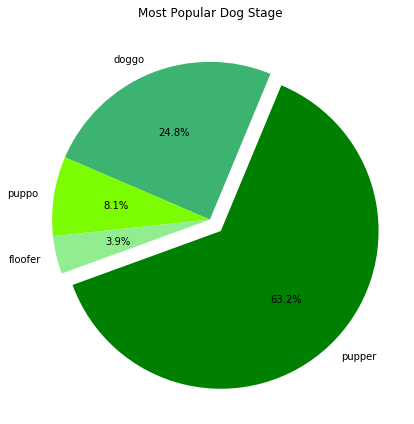

In [95]:
#define parameters
dog_stage_count = list(df[df['dog_stage'] != 'none']['dog_stage'].value_counts())[0:4]
dog_stages = df[df['dog_stage'] != 'none']['dog_stage'].value_counts().index.tolist()[0:4]
explode = (0.1,0 , 0, 0) 
colors = ['g', 'mediumseagreen', 'lawngreen', 'lightgreen']

#plot pie chart
figure1, axis1 = plt.subplots(figsize = (12,6))
axis1.pie(dog_stage_count, explode = explode, labels = dog_stages, colors=colors, autopct='%1.1f%%', startangle = 200)
plt.title("Most Popular Dog Stage")
plt.tight_layout()
plt.show();

In [111]:
#dog breed
top10_breeds_count = \
df[df.dog_breed_prediction != 'none'].dog_breed_prediction .value_counts().head(10)
print("Breed and number of tweets")
print("--------------------------")
print(top10_breeds_count)

top10_per = round(sum(top10_breeds_count) * 100 / df.shape[0])
print("\nTop 10 dog breeds make up {}% of all tweets".format(top10_per))

Breed and number of tweets
--------------------------
golden_retriever      134
Labrador_retriever     89
Pembroke               88
Chihuahua              78
pug                    54
chow                   41
Samoyed                39
Pomeranian             38
toy_poodle             36
malamute               29
Name: dog_breed_prediction, dtype: int64

Top 10 dog breeds make up 40% of all tweets


**What breed of dog is the highest and/or lowest rated?**

In [96]:
#lowest rated dog
df.nsmallest(2,['rating_over_10'])

,tweet_id,timestamp,text,rating_over_10,retweet_count,favorite_count,dog_name,dog_stage,dog_breed_prediction,prediction_confidence,source,expanded_urls
1190,678424312106393600,2015-12-20 03:58:55+00:00,This is Crystal. She's a shitty fireman. No sense of urgency. People could be dying Crystal. 2/10 just irresponsible https://t.co/rtMtjSl9pz,2.0,2462,5327,Crystal,none,Maltese_dog,0.759945,Twitter for iPhone,https://twitter.com/dog_rates/status/678424312106393600/photo/1
474,777885040357281792,2016-09-19 15:00:20+00:00,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,3.0,1628,6345,Wesley,none,Afghan_hound,0.123529,Twitter for iPhone,"https://twitter.com/dog_rates/status/777885040357281792/photo/1,https://twitter.com/dog_rates/status/777885040357281792/photo/1"


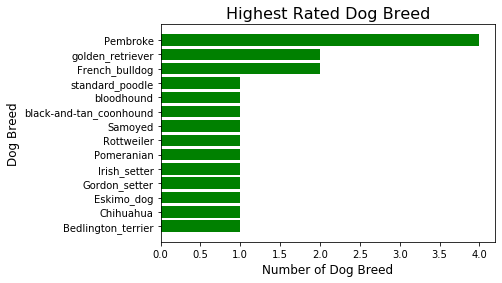

In [97]:
#Collate data
highest_rated = df[(df.rating_over_10 == 14)]
highest_rated = highest_rated.groupby(['dog_breed_prediction'])
highest_rated = highest_rated.tweet_id.count()
highest_rated = highest_rated.sort_values(ascending = False)
highest_rated

#Plot horizontal bar chart
plt.barh(highest_rated.index, highest_rated, color = 'g')

plt.xlabel('Number of Dog Breed', fontsize = 12)
plt.ylabel('Dog Breed', fontsize = 12)
plt.title('Highest Rated Dog Breed', fontsize = 16)
plt.gca().invert_yaxis()
plt.show();

In [98]:
#lowest retweeted dog
df.nsmallest(1,['retweet_count'])

,tweet_id,timestamp,text,rating_over_10,retweet_count,favorite_count,dog_name,dog_stage,dog_breed_prediction,prediction_confidence,source,expanded_urls
1553,666102155909144576,2015-11-16 03:55:04+00:00,Oh my. Here you are seeing an Adobe Setter giving birth to twins!!! The world is an amazing place. 11/10 https://t.co/11LvqN4WLq,11.0,11,70,None,none,English_setter,0.298617,Twitter for iPhone,https://twitter.com/dog_rates/status/666102155909144576/photo/1


In [99]:
#Top 5 most retweeted dogs
df.nlargest(5,['retweet_count'])

,tweet_id,timestamp,text,rating_over_10,retweet_count,favorite_count,dog_name,dog_stage,dog_breed_prediction,prediction_confidence,source,expanded_urls
659,744234799360020481,2016-06-18 18:26:18+00:00,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13.0,76281,153977,None,doggo,Labrador_retriever,0.825333,Twitter for iPhone,https://twitter.com/dog_rates/status/744234799360020481/video/1
687,739238157791694849,2016-06-04 23:31:25+00:00,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,13.0,56732,113828,None,doggo,Eskimo_dog,0.503372,Twitter for iPhone,https://twitter.com/dog_rates/status/739238157791694849/video/1
339,807106840509214720,2016-12-09 06:17:20+00:00,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,13.0,55610,118867,Stephan,none,Chihuahua,0.505370,Twitter for iPhone,https://twitter.com/dog_rates/status/807106840509214720/video/1
261,822872901745569793,2017-01-21 18:26:02+00:00,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13.0,42982,131330,None,puppo,Lakeland_terrier,0.196015,Twitter for iPhone,https://twitter.com/dog_rates/status/822872901745569793/photo/1
53,879415818425184262,2017-06-26 19:07:24+00:00,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,13.0,39971,98060,Duddles,none,English_springer,0.383404,Twitter for iPhone,https://twitter.com/dog_rates/status/879415818425184262/video/1


In [100]:
#Lowest favorited dog
df.nsmallest(1,['favorite_count'])

,tweet_id,timestamp,text,rating_over_10,retweet_count,favorite_count,dog_name,dog_stage,dog_breed_prediction,prediction_confidence,source,expanded_urls
1553,666102155909144576,2015-11-16 03:55:04+00:00,Oh my. Here you are seeing an Adobe Setter giving birth to twins!!! The world is an amazing place. 11/10 https://t.co/11LvqN4WLq,11.0,11,70,None,none,English_setter,0.298617,Twitter for iPhone,https://twitter.com/dog_rates/status/666102155909144576/photo/1


In [101]:
#top 10 most favorited dog
df.nlargest(5,['favorite_count'])

,tweet_id,timestamp,text,rating_over_10,retweet_count,favorite_count,dog_name,dog_stage,dog_breed_prediction,prediction_confidence,source,expanded_urls
659,744234799360020481,2016-06-18 18:26:18+00:00,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13.0,76281,153977,None,doggo,Labrador_retriever,0.825333,Twitter for iPhone,https://twitter.com/dog_rates/status/744234799360020481/video/1
261,822872901745569793,2017-01-21 18:26:02+00:00,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13.0,42982,131330,None,puppo,Lakeland_terrier,0.196015,Twitter for iPhone,https://twitter.com/dog_rates/status/822872901745569793/photo/1
339,807106840509214720,2016-12-09 06:17:20+00:00,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,13.0,55610,118867,Stephan,none,Chihuahua,0.505370,Twitter for iPhone,https://twitter.com/dog_rates/status/807106840509214720/video/1
101,866450705531457537,2017-05-22 00:28:40+00:00,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr",13.0,32399,115001,Jamesy,pupper,French_bulldog,0.905334,Twitter for iPhone,"https://twitter.com/dog_rates/status/866450705531457537/photo/1,https://twitter.com/dog_rates/status/866450705531457537/photo/1"
687,739238157791694849,2016-06-04 23:31:25+00:00,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,13.0,56732,113828,None,doggo,Eskimo_dog,0.503372,Twitter for iPhone,https://twitter.com/dog_rates/status/739238157791694849/video/1


**What is the relationship between rating, retweets and favorites?**
Bivariate Analysis

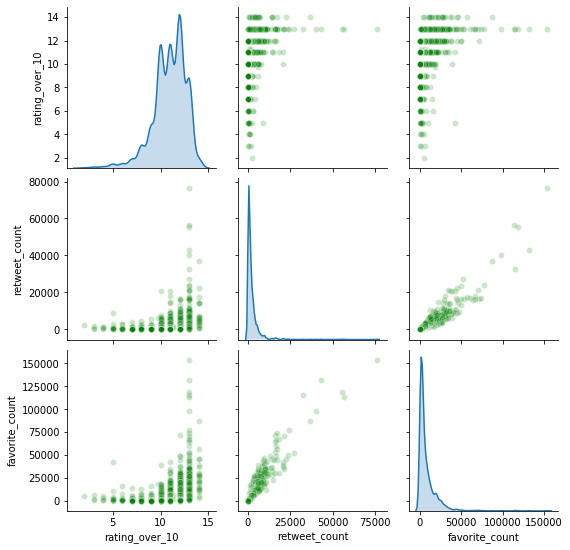

In [102]:
sns.pairplot(df, 
             vars = ['rating_over_10', 'retweet_count', 'favorite_count'], 
             diag_kind = 'kde', plot_kws = {'color': 'g','alpha': 0.2});

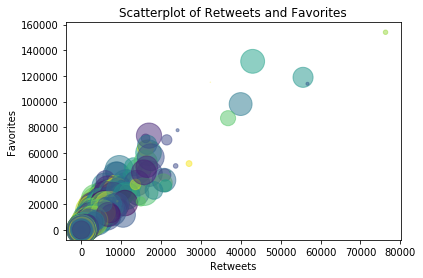

In [112]:
#Scatterplot of retweets and favorites
N= df.shape[0]
x = df.retweet_count
y = df.favorite_count
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.xlabel('Retweets')
plt.ylabel('Favorites')
plt.title('Scatterplot of Retweets and Favorites')

plt.show();

**What is the best dog across category?**

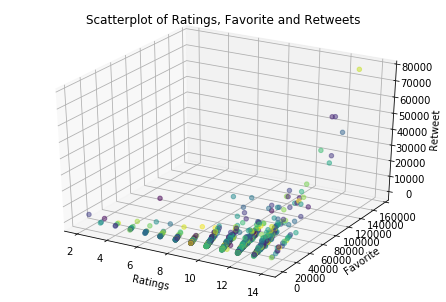

In [103]:
#3D scatterplot of rating, retweets and favorite
fig = pyplot.figure()
ax = Axes3D(fig)

N = N= df.shape[0]
x = df.rating_over_10
y = df.favorite_count
z = df.retweet_count
colors = np.random.rand(N)

ax.scatter(x, y, z, c=colors, alpha=0.5)

ax.set_xlabel('Ratings')
ax.set_ylabel('Favorite')
ax.set_zlabel('Retweet')
ax.set_title('Scatterplot of Ratings, Favorite and Retweets')

pyplot.show()

<a id='conclusion'></a>

## 6.0 Conclusion

1. What is the most popular dog_stage?
> The *Pupper* which makes up 63.2% is the most popular dog stage

2. What breed of dog have the highest average rating?
> *Pembroke* has the highest average rating.

3. Is there a relationship between rating, retweets, likes and breed of dog?
> Retweets and likes are positively correlated. 

4. What is the best dog across category?
> The best dog across category is an **Labrador Retriever**- a doggo with a score of 13/10,  76,281 retweet and 153,977	likes

**Putting it all together...**

After wrangling data from @dog_rates twitter archive, an image prediction file and querying Twitter API, a cleaned dataset consisting of **1,568** original tweets that *rated dogs* was collated. These tweets which rated 111 dog breeds were posted between November 15, 2015 and August 1, 2017. Of the rated dogs, 63.2% are pupper, 24.8% are doggy, 8.1% are puppo while 3.9% are floffer.

<br> **Rating**
<br>Rating was done over 10 and it ranged from 2 (Crystal- a Maltese dog) to 14 (a title held by 24 dogs). The highest rated (rating = 14) dog species is Pembroke, closely followed by the Golden Retriever and French BullDog.

<br> **Retweets**
<br> The tweet with the lowest retweet has 11 retweets while the highest had 76,281 retweets- this was 19,547 retweets more the the second highest retweet (which was tweeted 14 days before it). It was observed that **4/5 of the most retweeted were videos of dogs participating in 'fun' activities  such as standing on water, blowing bubbles in a bowl of water etc.**

<br> **Favorite**
<br> The least retweeted dog, managed to make it as the least favorited dog (70). A further review of the data shows that the post was made on the second day of the handle's creation. This indicates that the handle probably did not have enough users/reach when the post was made.
4/5 of the top 5 retweeted dogs made to the top 5 most favorited dogs. The most retweeted dog maintains a first place with 153,995 favorites (22,677 more favorites over the second position!).

Overall, the unnamed dog in the tweet - *'Here's a doggo realizing you can stand in a pool. 13/10 enlightened af'* is clearly the MVP. This can be tied to the fact that the tweet includes a video showing a doggo standing comfortable in water- a feat only the brave undertake! Recollect that 4/5 of the most retweeted tweets were videos of dogs in water-related activity.

Finally, if you are aiming for high number of retweets for a dog-related tweet, a video of the dog in a water-related activity is a winner.

## References
1. https://matplotlib.org/3.3.1/tutorials/introductory/sample_plots.html#sphx-glr-tutorials-introductory-sample-plots-py
2. https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
3. https://cmdlinetips.com/2019/03/how-to-select-top-n-rows-with-the-largest-values-in-a-columns-in-pandas/
4. https://python-graph-gallery.com/196-select-one-color-with-matplotlib/